Code for object detection is taken from [here](https://github.com/cfotache/pytorch_objectdetecttrack) and modified to work with the video instead of images.

Before running this file, be sure that the `config/yolov3.weights` file is downloaded, otherwise run the `config/download_weights.sh` script.

In [1]:
from models import Darknet
from utils import utils

import os, sys, time, datetime, random
import numpy as np
from collections import defaultdict
import json
from tqdm.notebook import tqdm
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import cv2

In [2]:
# Load true bounding boxes.
with open('data/input_annotations.json') as in_file:
    annotations = json.load(in_file)
true_tracks = defaultdict(list)
for annot in annotations['annotations']:
    true_tracks[annot['image_id']].append(annot['bbox'])

In [3]:
config_path = 'config/yolov3.cfg'
weights_path = 'config/yolov3.weights'
class_path = 'config/coco.names'
input_size = 416
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualise the detection or not.
visualize = False
# Class confidence and non-max suppression threshholds for object detection.
conf_thres=0.2
nms_thres=0.4

# Load model and weights.
model = Darknet(config_path, img_size=input_size)
model.load_weights(weights_path)
model.to(device)
model.eval()
classes = utils.load_classes(class_path)

C:\Users\kzvda\Anaconda3\envs\test\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
def detect_image(model, img, input_size):
    """Detect the objects on the image.
    
    Scales input image to the needed size keeping the aspect ratio.
    Merges classes that are close to the car (bus, train, truck).
    Performes non-max suppression on resulting bboxes.
    """
    # Get device from the model
    device = next(model.parameters()).get_device()
    device = device if device > -1 else 'cpu'
    ratio = min(input_size / img.shape[0], input_size / img.shape[1])
    imw = round(img.shape[0] * ratio)
    imh = round(img.shape[1] * ratio)
    img = cv2.resize(img, (imh, imw))
    img = cv2.copyMakeBorder(img,
                             max(int((imh - imw) / 2), 0), # top
                             max(int((imh - imw) / 2), 0), # bottom
                             max(int((imw - imh) / 2), 0), # left
                             max(int((imw - imh) / 2), 0), # right
                             cv2.BORDER_CONSTANT, value=128)
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image_tensor = torch.Tensor(np.asarray(img)).float().to(device)
    image_tensor = image_tensor.permute((2, 0, 1))
    image_tensor = image_tensor.unsqueeze_(0)
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(image_tensor)
        for class_id in [10, 11, 12]: # 5 + class_id; 3 - motorbike; 5 - bus; 6 - train; 7 - truck
            detections[:, :, 7] = torch.max(detections[:, :, 7], detections[:, :, class_id]) 
            detections[:, :, class_id] = 0
        # num_of_classes = 7, because we need only first 7
        detections = utils.non_max_suppression(detections, 7, conf_thres, nms_thres)
    return detections[0]

def scale_bboxes(bboxes, from_shape, to_shape):
    """Scale the bboxes coordinates.
    
    :param bboxes: bboxes in format (x1, y1, x2, y2, *data).
    """
    pad_x = max(to_shape[0] - to_shape[1], 0) * (from_shape / max(to_shape))
    pad_y = max(to_shape[1] - to_shape[0], 0) * (from_shape / max(to_shape))
    unpad_h = from_shape - pad_y
    unpad_w = from_shape - pad_x
    # browse detections and draw bounding boxes
    for i, (x1, y1, x2, y2, *_) in enumerate(bboxes):
        box_h = ((y2 - y1) / unpad_h) * to_shape[0]
        box_w = ((x2 - x1) / unpad_w) * to_shape[1]

        x1 = ((x1 - pad_x // 2) / unpad_w) * to_shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * to_shape[0]
        bboxes[i][:4] = x1, y1, x1 + box_w, y1 + box_h
    return bboxes

In [5]:
# Input video.
cap = cv2.VideoCapture('data/input.avi')
# Output video.
out = cv2.VideoWriter('data/out.avi', cv2.VideoWriter_fourcc(*'XVID'), 23.63, (1920, 1088))


# Check if camera opened successfully.
if (cap.isOpened()== False):
    print("Error opening video stream or file")

pr_tracks = defaultdict(list)
pr_confidence = defaultdict(list)
frame_num = 1

# Get the number of frames
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total=frame_count, desc='Object Detection')
# Read until video is completed.
while(cap.isOpened()):
    # Capture frame-by-frame.
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert to RGB and detect objects.
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    detections = detect_image(model, rgb_frame, input_size).cpu().detach().numpy()
    detections = scale_bboxes(detections, input_size, frame.shape)


    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        # If detected car, add to the predicted tracks.
        if classes[int(cls_pred)] == 'car':
            pr_tracks[frame_num].append((x1.item(), y1.item(), (x2 - x1).item(), (y2 - y1).item()))
            pr_confidence[frame_num].append(cls_conf)
            # Visualise the predicted bbox and class.
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame, classes[int(cls_pred)], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0))

            # Visualise the ground truth bboxes.
            for x1, y1, w, h in true_tracks[frame_num]:
                x1, y1, w, h = int(x1), int(y1), int(w), int(h)
                cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)
    if visualize:
        cv2.imshow('Frame', frame)
    out.write(frame)
    frame_num += 1
    pbar.update(1)
    # Press Q on keyboard to  exit.
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

pbar.close()
# When everything done, release objects.
cap.release()
out.release()

cv2.destroyAllWindows()

### Calculate the precision-recall curve and AP

In [6]:
precision, recall = utils.compute_precision_recall_curve(true_tracks, pr_tracks, pr_confidence, thresh=0.5)

ap = utils.compute_ap(recall, precision)
print(f'AP score: {ap:.4f}')

AP score: 0.4610


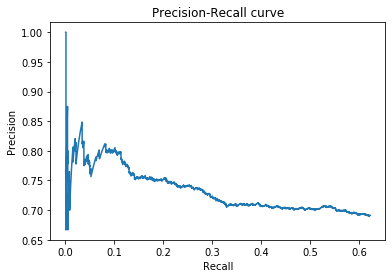

In [7]:
from matplotlib import pyplot as plt
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)
plt.show()